## Import essential libraries

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time
from collections import Counter

%matplotlib inline
plt.style.use('ggplot')

import miner

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Define paths to data and results

In [2]:
# Path to the miner directory
proj_path = os.path.join(os.path.expanduser('~'),'Projects','miner3')
input_path = os.path.join(proj_path, 'miner_mindata')

# create name for results folder where output files will be saved
resultsFolder = "results_miner"

# create results directory
resultsDirectory = os.path.join(proj_path,resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)
# name of the folder containing the miner network
networkFolder = "results_minCorrelation_0o2_50_allFiles"
network_path = os.path.join(proj_path, networkFolder)

## Load data

In [4]:
# Load expression Data
expressionFile = os.path.join(input_path, "expression","IA12Zscore.csv")
id_names = os.path.join(input_path, "identifier_mappings.txt")
expressionData, conversionTable = miner.preprocess(expressionFile, id_names)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path, 'mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(network_path, "coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(network_path, "coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(network_path, "regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(network_path,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(network_path,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(network_path, "overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(network_path, "underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(network_path, "eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load table for converting gene names
id_table = pd.read_csv(id_names,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

completed identifier conversion.
16216 genes were converted.


In [6]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(network_path, 'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [7]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(network_path, 'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

## Format transcriptional program and states data for analysis

In [8]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes
    
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = pr_genes
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

# write membership matrices to .csv file
overExpressedProgramsMatrix_pr = miner.membershipToIncidence(overExpressedMembers_pr,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedProgramsMatrix_pr = miner.membershipToIncidence(underExpressedMembers_pr,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

# Generate program activity difference matrix
dfr_pr = overExpressedProgramsMatrix_pr - underExpressedProgramsMatrix_pr

done!
done!


In [10]:
# Identify baseline and relapse patients
baseline_patients = [name for name in expressionData.columns if name.split("_")[2]=='1']
relapse_patients = [name for name in expressionData.columns if name.split("_")[2]=='2']
all_relapse_patients = [name for name in expressionData.columns if name.split("_")[2]!='1']
print('Baseline:',len(baseline_patients),'First relapse:',len(relapse_patients),'\nAny relapse:',len(all_relapse_patients))

states_df = pd.DataFrame(np.zeros((len(states),expressionData.shape[1])))
states_df.index = list(range(1,len(states)+1))
states_df.columns = expressionData.columns

for i in range(len(states)):
    states_df.loc[i+1,states[i]] = 1


state_labels = pd.DataFrame(np.zeros((expressionData.shape[1],1)))
state_labels.index = expressionData.columns
state_labels.columns = ["state"]
for j in range(states_df.shape[0]):
    s = states_df.index[j]
    state_labels.loc[states[j],"state"] = int(s)

state_labels.head()

Baseline: 779 First relapse: 56 
Any relapse: 102


,state
MMRF_1270_1_BM,16.0
MMRF_1037_1_BM,4.0
MMRF_2644_1_BM,1.0
MMRF_1235_1_BM,9.0
MMRF_1621_1_BM,4.0


## Load causal anchor matrices

In [11]:
# Load mutation matrices
common_mutations_file = os.path.join(input_path,"mutations","commonMutations.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)

translocations_file = os.path.join(input_path,"mutations","translocationsIA12.csv")
translocations = pd.read_csv(translocations_file,index_col=0,header=0)

cytogenetics_file = os.path.join(input_path,"mutations","cytogenetics.csv")
cytogenetics = pd.read_csv(cytogenetics_file,index_col=0,header=0)

## Perform causal analysis

In [12]:
# Define reference information for causal analysis
referenceDictionary = regulonModules
referenceRegulonDf = regulonDf
referenceDf = eigengenes
reference_patients = expressionData.columns

#Identify reference genotype or phenotype matrix as "mut_matrix"
#Using states_df is akin to differential expression analysis of states
#The causal results will show regulons that are perturbed in each state

mut_matrix = states_df.copy()
mut_matrix.index = np.array(mut_matrix.index).astype(str)

In [13]:
# #Test some other group of patients
# relapse_df = pd.DataFrame(np.zeros((1,expressionData.shape[1])))
# relapse_df.columns = expressionData.columns
# relapse_df.loc[0,relapse_patients] = 1

# mut_matrix = relapse_df.copy()
# mut_matrix.index = np.array(mut_matrix.index).astype(str)

In [14]:
#Perform causal analysis using mut_matrix for anchors
causal_results_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_subdirectory = "causal_results"
causal_states = miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),
                                            expression_matrix=expressionData.copy(),
                                            reference_matrix=referenceDf.copy(),
                                            mutation_matrix=mut_matrix,
                                            resultsDirectory=causal_results_directory,
                                            minRegulons=1,significance_threshold=0.05,
                                            causalFolder=causal_subdirectory)


Creating directories if dont exist
Testing correlation of TF and cluster eigengene.
Looping through each mutation
completed causal analysis in 0.38 minutes


In [15]:
# compile all causal results
# If states_df was passed as mut_matrix, the state is under the "Mutation" heading
causal_states_directory = os.path.join(causal_results_directory,causal_subdirectory)
causal_states = miner.readCausalFiles(causal_states_directory)
causal_states.to_csv(os.path.join(resultsDirectory,"CausalStatesResults.csv"))
print(causal_states.shape)
causal_states.head()

(22071, 13)


,Mutation,Regulator,Regulon,MutationRegulatorEdge,-log10(p)_MutationRegulatorEdge,RegulatorRegulon_Spearman_R,RegulatorRegulon_Spearman_p-value,Regulon_stratification_t-statistic,-log10(p)_Regulon_stratification,Fraction_of_edges_correctly_aligned,Fraction_of_aligned_and_diff_exp_edges,number_downstream_regulons,number_differentially_expressed_regulons
1098,4,ENSG00000150347,R-1098,-1.0,19.109624,0.307284,1.014489e-20,-4.544455,4.924186,0.5,0.5,4,4
1095,4,ENSG00000150347,R-1095,-1.0,19.109624,0.652064,8.448209e-108,-5.988572,8.204772,0.5,0.5,4,4
2410,4,ENSG00000162772,R-2410,-1.0,1.448896,0.277550,4.784454e-17,-6.100086,8.332058,1.0,1.0,4,4
2409,4,ENSG00000162772,R-2409,-1.0,1.448896,0.426430,3.088059e-40,-10.466139,22.134879,1.0,1.0,4,4
2412,4,ENSG00000162772,R-2412,-1.0,1.448896,0.399891,3.679580e-35,-3.570829,3.314984,1.0,1.0,4,4


## Load databases for TF-TF network inference

In [17]:
#Index network dataframe with regulon id
regulonDf_regid = regulonDf.copy()
regulonDf_regid.index = regulonDf_regid.Regulon_ID

#Load reference TFBSDB database oriented from targets to tfs
tfbsdb_genes_to_tf = miner.read_pkl(os.path.join(input_path,"network_dictionaries","tfbsdb_genes_to_tf.pkl"))

#Load reference chip-seq database
chea_genes_to_tf = miner.read_pkl(os.path.join(input_path,"network_dictionaries","chea_reciprocal.pkl"))


## Filter causal results to generate high-confidence network

In [18]:
#Select state or mutation ID to perform further analysis
anchor_id = 2

#Subset causal results to anchor_id
causal_subset = causal_states.iloc[np.where(causal_states.Mutation==anchor_id)[0],:]

#Filter causal results to generate high-confidence network
#The "Fraction_of_aligned_and_diff_exp_edges" parameter controls which regulons are kept
#If a regulator is differentially expressed, and its targeted regulons are differentially
#expressed in the direction consistent with the regulator-target regulon edge, a causal link
#is drawn from the state or mutation to the regulator and regulons. We do not require that
#every regulon downstream of a regulator is differentially expressed. The proportion that
#must be differentially expressed is defined by the "Fraction_of_aligned_and_diff_exp_edges" parameter. 

#Apply default parameter of 0.5, or customize between [0,1] (1 is most stringent)
fraction_of_impacted_regulons = 0.5
causal_subset = causal_subset.iloc[np.where(causal_subset.Fraction_of_aligned_and_diff_exp_edges>fraction_of_impacted_regulons)[0],:]
causal_subset.sort_values(by="Fraction_of_aligned_and_diff_exp_edges",ascending=False,inplace=True)

#Separate TFs that are activated or repressed in causal subset
mut_act = causal_subset[causal_subset.MutationRegulatorEdge==1].Regulator.unique()
mut_rep = causal_subset[causal_subset.MutationRegulatorEdge==-1].Regulator.unique()

print("{:d} causal flows specific to subset".format(causal_subset.shape[0]))

945 causal flows specific to subset


## List regulators specific to causal subset

In [19]:
#List regulators specific to causal subset
from collections import Counter
regulator_count = Counter(causal_subset.Regulator)
reglist = [g[0] for g in regulator_count.most_common()]
regulator_count.most_common()[0:10]

[('ENSG00000068305', 23),
 ('ENSG00000105856', 22),
 ('ENSG00000153879', 20),
 ('ENSG00000162702', 20),
 ('ENSG00000125347', 19),
 ('ENSG00000071564', 19),
 ('ENSG00000065970', 19),
 ('ENSG00000164916', 19),
 ('ENSG00000143190', 19),
 ('ENSG00000124782', 19)]

## Define output directory for TF-TF network inference

In [20]:
#Create results directory
if not os.path.isdir(os.path.join(resultsDirectory,str(anchor_id))):
    os.mkdir(os.path.join(resultsDirectory,str(anchor_id)))
tf_network_directory = os.path.join(resultsDirectory,str(anchor_id),"tf-epi_network")

if not os.path.isdir(tf_network_directory):
    os.mkdir(tf_network_directory)

## Predict TF-TF network

In [21]:
# Predict expression of each TF in network from other TFs in network
# Require that predictor TFs have binding site for target TF
# Supply TFBSDB and CHiP-seq database information for binding sites

from sklearn.linear_model import Lasso
import warnings

#Suppress warnings
warnings.filterwarnings("ignore")

#Set parameters for LASSO model
lambda_min = 0.1
n_iter = 50
reference_database = tfbsdb_genes_to_tf
reference_database2 = chea_genes_to_tf

#Create list to collect predictive performance measures
predictive_performance = []
for tf_ix in range(len(reglist)):
    #Identify TFs with binding sites in target TF promoter
    tf = reglist[tf_ix]
    
    matches = []
    if tf in reference_database.keys():
        matches = reference_database[tf]
 
    matches_2 = []
    if reference_database2 is not None:
        if tf in reference_database2.keys():
            matches_2 = reference_database2[tf]
        
    matches = list(set(matches)|set(matches_2))    
    hits = miner.intersect(reglist,matches)

    #Remove target TF from predictors
    hits = miner.setdiff(hits,[tf])
    if len(hits) == 0:
        print(tf+" has no upstream tfs")
        continue

    #Loop over coefficient thresholds to identify optimal model
    mean_rs = []
    mean_coefs = []
    hitlist = []
    hitlist.append(hits)
    for threshold in np.arange(0.01,0.21,0.01):
        #Generate matrices for TF-TF network inferences
        if len(hits)>0:
            tmp_x = np.array(expressionData.loc[hits,reference_patients])
            tmp_y = np.array(expressionData.loc[tf,reference_patients])

        # Perform n_iter bootstrap iterations of predicting TF expression
        coefs = []
        rs = []
        for iter in range(n_iter):
            #Split data into training and test sets
            train_test_dict = miner.train_test(tmp_x,tmp_y,reference_patients)
            X = train_test_dict["x_train"].T
            y = train_test_dict["y_train"]

            #Generate LASSO model to predict TF expression
            clf = Lasso(random_state=0,alpha=lambda_min,fit_intercept=True)
            clf.fit(X, y) 

            #Retrieve model coefficients for weight of each TF in predicting target TF
            coef = clf.coef_
            coefs.append(coef)

            #Evaluate performace of predictor
            y_ = train_test_dict["y_test"]
            decision_function_score = clf.predict(train_test_dict["x_test"].T)
            r, p = stats.spearmanr(decision_function_score,train_test_dict["y_test"])
            rs.append(r)

        #Use the mean coefficient of all bootstrap runs for the final TF coefficients
        mean_coef = np.mean(np.vstack(coefs),axis=0)
        mean_coefs.append(mean_coef)

        #Use the mean correlation coefficient as the final performace metric
        mean_r = np.mean(np.vstack(rs),axis=0)
        #print("Mean Spearman correlation of model to target expression: {:.3f}".format(mean_r[0]))
        mean_rs.append(mean_r)

        #Restrict hits by thresholding coefficients for the next iteration
        hits = np.array(hits)[np.abs(mean_coef)>threshold]
        hitlist.append(hits)

        if len(hits) == 0:
            break

    #Set cut-off model performance
    #This makes the model as sparse as possible while maintaing
    #performance > thresh
    thresh = 0.975*mean_rs[0]

    #Identify optimal model
    filter_ = np.where(mean_rs<thresh)[0]
    if len(filter_) > 0:
        selection = np.where(mean_rs<thresh)[0][0]-1
    
    elif len(filter_)==0:
        selection = len(mean_rs)-1

    #Convert the ensembl ids to hgnc
    tf_names = miner.gene_conversion(hitlist[selection],id_table=id_table,list_symbols=True)
    target_name = miner.gene_conversion(tf,id_table=id_table,list_symbols=True)

    #List number of coefficients in each model
    len_coefs = [len(c) for c in mean_coefs]

    #Define output directory to save optimized model
    output_dir = os.path.join(tf_network_directory,target_name[0])
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    #Write model to file
    tmp_output = pd.DataFrame(mean_coefs[selection])
    tmp_output.columns = ["Coefficient"]
    tmp_output.index = tf_names
    tmp_output.to_csv(os.path.join(output_dir,"model.csv"))
    
    predictive_performance.append(mean_rs[selection][0])
    print("completed ",target_name[0]," model")


completed  MEF2A  model
completed  HBP1  model
completed  CEBPG  model
completed  ZNF281  model
completed  IRF1  model
completed  TCF3  model
completed  FOXJ2  model
completed  FOXK1  model
completed  POU2F1  model
completed  RREB1  model
completed  RFX3  model
completed  EWSR1  model
completed  FOXJ3  model
completed  ETV6  model
completed  FOXO1  model
completed  FOXP1  model
completed  NFKB1  model
completed  PRDM1  model
completed  SPDEF  model
completed  ZNF143  model
completed  SP1  model
completed  ZEB1  model
completed  ELF3  model
completed  ELF4  model
completed  XBP1  model
completed  NR3C1  model
completed  RORA  model
completed  ELK1  model
completed  TP53  model
completed  IRX3  model
completed  MAFK  model
completed  MAZ  model
completed  FOXI1  model
completed  ARID5A  model
completed  ZBTB16  model
completed  CEBPA  model
completed  CREB1  model
completed  FOXO3  model
completed  KLF7  model
completed  ATF1  model
completed  ZNF410  model
completed  SRF  model
complete

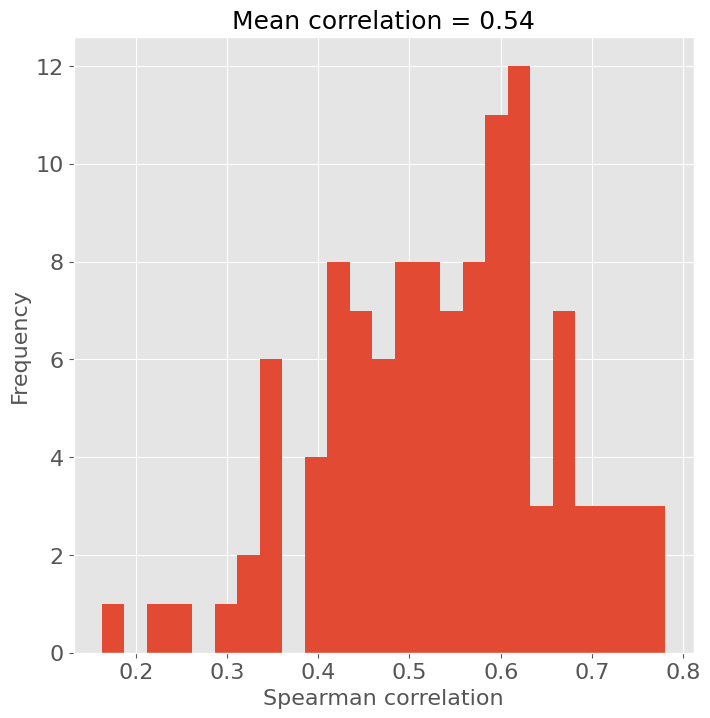

In [22]:
#Save histogram of predictive performace
plt.figure(figsize=(8,8))
plt.hist(predictive_performance,bins=25)
plt.ylabel("Frequency",fontsize=16)
plt.xlabel("Spearman correlation",fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title("Mean correlation = {:.2f}".format(np.nanmean(predictive_performance)),
         fontsize=18)
plt.savefig(os.path.join(tf_network_directory,"predictive_performace.pdf"),bbox_inches="tight")

## Compile tf-tf network from individual models

In [23]:
#List filenames from tf_network_directory
filenames = [x[0] for x in os.walk(tf_network_directory)]

#Read predictive models for each TF in network
lines = []
for filename in filenames[1:]:
    target = os.path.basename(os.path.normpath(filename))
    if target == 'epi-tf_network':
        continue
    if target == 'tf-tf_network':
        continue
    if target == os.path.basename(os.path.normpath(tf_network_directory)):
        continue
    
    model_df = pd.read_csv(os.path.join(filename,"model.csv"),index_col=0,header=0)
    
    for ix in model_df.index:
        tmp = [ix,model_df.loc[ix,"Coefficient"],target]
        lines.append(tmp)

#Write edges into a TF network
tf_network = pd.DataFrame(np.vstack(lines))
tf_network.columns = ["Source","Edge","Target"]
tf_network = tf_network[np.abs(np.array(tf_network.Edge).astype(float))>0.0]
tf_network.to_csv(os.path.join(tf_network_directory,"tf_tf_network.csv"))
tf_network.head()

,Source,Edge,Target
0,MEF2A,-0.0443861011164973,TERF1
1,TCF3,0.1292934525960795,TERF1
2,POU2F1,0.1091265599014853,SP100
3,FLI1,0.1270523908157708,SP100
4,NFKB1,0.0738119658255668,SP100


## Calculate network parameters for each TF

In [24]:
#Create Table of in- and out-degrees
out_degree = []
in_degree = []

for tf in tf_network.Target.unique():
    tmp_in = sum(1*(tf_network.Target==tf))
    tmp_out = sum(1*(tf_network.Source==tf))
    out_degree.append(tmp_out)
    in_degree.append(tmp_in)
    
#Calculate ratio of out-degree to in-degree
out_over_in = list(np.array(out_degree)/np.array(in_degree).astype(float))

#Format information as dataframe
network_degrees = pd.DataFrame(np.vstack([in_degree,out_degree,out_over_in]).T)
network_degrees.columns = ["in_degree","out_degree","out/in"]
network_degrees.index = tf_network.Target.unique()
network_degrees.sort_values(by="out/in",ascending=False,inplace=True)

#Reconvert index to ensembl
ensembl_index = miner.gene_conversion(network_degrees.index,
                      input_type="symbol",
                      output_type="ensembl.gene",
                      id_table=id_table,
                      list_symbols=True)

#Format ensembl index for integration
alt_id = pd.DataFrame(ensembl_index)
alt_id.columns = ["Alt_ID"]
alt_id.index = network_degrees.index

#Append ensembl index to network output
network_degrees = pd.concat([alt_id,network_degrees],axis=1)
network_degrees.to_csv(os.path.join(tf_network_directory,"tf_tf_network_degrees.csv"))

#Write to file
network_degrees.head()

,Alt_ID,in_degree,out_degree,out/in
E2F1,ENSG00000101412,1.0,13.0,13.0
MAFK,ENSG00000198517,2.0,16.0,8.0
POU2F1,ENSG00000143190,3.0,24.0,8.0
FOXJ3,ENSG00000198815,6.0,27.0,4.5
MYBL2,ENSG00000101057,1.0,4.0,4.0


## Probe TFs in TF-TF network

In [25]:
#Investigate regulators of a specific TF in the TF-TF network
myc_upstream = tf_network[tf_network.Target=="MYC"]
print(myc_upstream)

#Investigate targets of a specific TF in the TF-TF network
myc_downstream = tf_network[tf_network.Source=="MYC"]
print("\n",myc_downstream)

Empty DataFrame
Columns: [Source, Edge, Target]
Index: []

 Empty DataFrame
Columns: [Source, Edge, Target]
Index: []


## Draw TF network

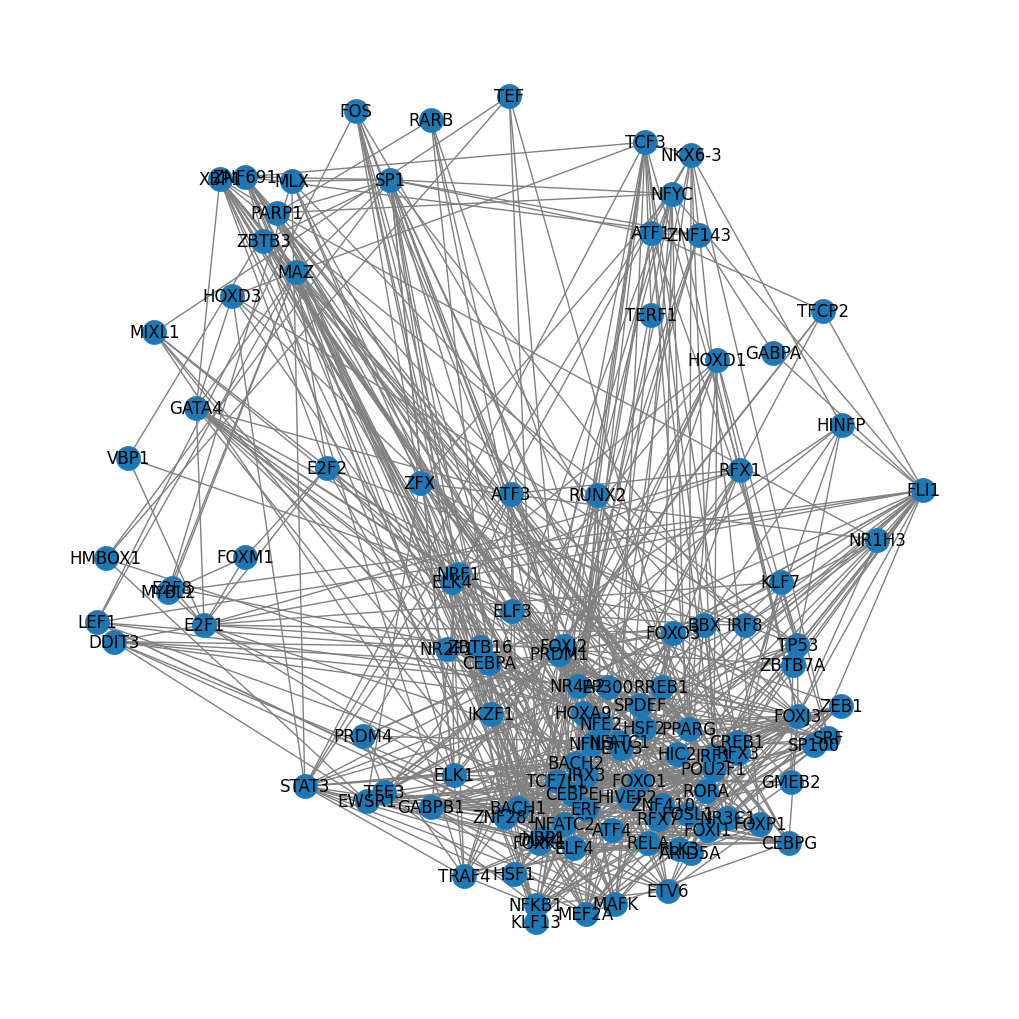

In [27]:
import networkx as nx

# instantiate graph and add edge information
G = nx.Graph()
elist = []
for i in range(tf_network.shape[0]):
    src = tf_network.iloc[i,0]
    tgt = tf_network.iloc[i,-1]
    edg = tf_network.iloc[i,1]
    elist.append((src,tgt,edg))
    
# create graph
G.add_weighted_edges_from(elist)

#Get positions of nodes
positions = nx.spring_layout(G)

#Plot network
plt.figure(figsize=(10,10))
nx.draw(G,positions,with_labels=True,edge_color = 'gray')

## Generate initial TF-target tfs dictionary for master regulator analysis

In [28]:
#Reconvert index to ensembl
ensembl_source = miner.gene_conversion(list(tf_network.Source),
                      input_type="symbol",
                      output_type="ensembl.gene",
                      id_table=id_table,
                      list_symbols=True)

#Format for integration
alt_source = pd.DataFrame(ensembl_source)
alt_source.columns = ["Source"]
alt_source.index = tf_network.index

#Reconvert index to ensembl
ensembl_target = miner.gene_conversion(list(tf_network.Target),
                      input_type="symbol",
                      output_type="ensembl.gene",
                      id_table=id_table,
                      list_symbols=True)

#Format for integration
alt_target = pd.DataFrame(ensembl_target)
alt_target.columns = ["Target"]
alt_target.index = tf_network.index

#Binarize edges
bin_edges = [1 if edge>0 else -1 for edge in np.array(tf_network.Edge).astype(float)]

#Format for integration
alt_edge = pd.DataFrame(bin_edges)
alt_edge.columns = ["Edge"]
alt_edge.index = tf_network.index

#Append to network output
tf_network_ensembl = pd.concat([alt_source,alt_edge,alt_target],axis=1)

#Create dictionary with TF as keys and direct targets as elements
tf_tf_dictionary = {tf:miner.get_downstream_tfs(tf,tf_network_ensembl) for tf in reglist}

## Generate expanded TF-target tfs dictionary for master regulator analysis

In [29]:
#Create dictionary of TF:target tfs that further requires TF-target edge aligns
#with causal edge (i.e., if target is up-regulated, but TF down-regulates target,
#the TF-target pair is NOT included)
aligned_tfs_primary = miner.downstream_tf_analysis(reglist,tf_network_ensembl,causal_subset)

#Create dataframe of TFs and number of aligned direct targets
len_primaries = [len(aligned_tfs_primary[tf]) for tf in aligned_tfs_primary.keys()]
len_primaries = pd.DataFrame(len_primaries)
len_primaries.columns = ["out_degree_aligned"]
len_primaries.index = miner.gene_conversion(list(aligned_tfs_primary.keys()),
                                           id_table=id_table,
                                           list_symbols=True)
len_primaries.sort_values(by="out_degree_aligned",ascending=False,inplace=True)

#Subset to regulators that drive toward state
master_attractors = len_primaries.loc[miner.gene_conversion(mut_act,id_table=id_table,list_symbols=True),:]
master_attractors.sort_values(by="out_degree_aligned",ascending=False,inplace=True)
print("Master attractors")
print(master_attractors.head(10))

#Write to file
master_attractors.to_csv(os.path.join(tf_network_directory,"master_attractors.csv"))

#Subset to regulators that drive away from state
master_repellers = len_primaries.loc[miner.gene_conversion(mut_rep,id_table=id_table,list_symbols=True),:]
master_repellers.sort_values(by="out_degree_aligned",ascending=False,inplace=True)
print("\nMaster repellers")
print(master_repellers.head(10))

#Write to file
master_repellers.to_csv(os.path.join(tf_network_directory,"master_repellers.csv"))
print("\n")

#Generate dictionary of TF-downstream tfs, where n_propagate=2 includes the direct targets of 
#the TF's direct targets (i.e., children and grandchildren)
n_propagate = 2
coverage_dict_act, span_dict_act = miner.propagate_network(mut_act,aligned_tfs_primary,n_propagate=n_propagate)
coverage_dict_rep, span_dict_rep = miner.propagate_network(mut_rep,aligned_tfs_primary,n_propagate=n_propagate)

Master attractors
        out_degree_aligned
FOXJ3                   24
POU2F1                  23
MEF2A                   17
FOXK1                   17
FOXO1                   15
ZNF281                  15
FOXJ2                   15
HBP1                    14
MAFK                    14
IRF1                    14

Master repellers
       out_degree_aligned
SP1                    13
E2F1                   12
TCF3                   10
TP53                   10
MAZ                     9
PPARG                   8
GATA4                   7
CEBPA                   6
CEBPE                   5
PARP1                   4


completed network propagation in 9.491e-04 seconds
completed network propagation in 3.154e-04 seconds


## Cluster regulators by common targets

Jaccard activators
                 ENSG00000162772  ENSG00000118260  ENSG00000175592
ENSG00000162772         1.000000         0.181818         0.173913
ENSG00000118260         0.181818         1.000000         0.066667
ENSG00000175592         0.173913         0.066667         1.000000
ENSG00000178951         0.181818         0.200000         0.047619
ENSG00000101216         0.026316         0.176471         0.000000 

Jaccard repressors
                 ENSG00000162772  ENSG00000118260  ENSG00000175592
ENSG00000162772         1.000000         0.181818         0.173913
ENSG00000118260         0.181818         1.000000         0.066667
ENSG00000175592         0.173913         0.066667         1.000000
ENSG00000178951         0.181818         0.200000         0.047619
ENSG00000101216         0.026316         0.176471         0.000000


Text(0.5, 1.0, 'Repressed TFs (unclustered)')

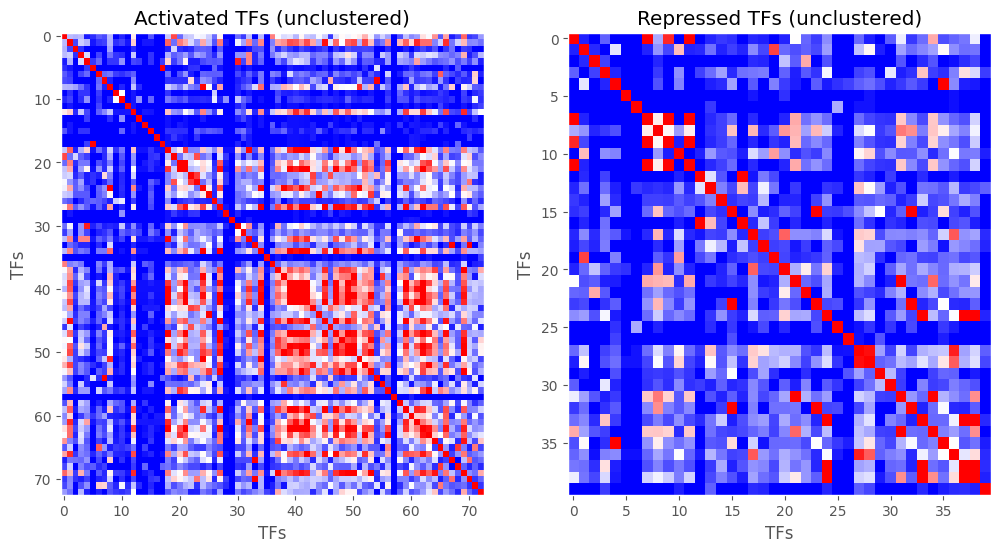

In [30]:
#Generate pairwise matrix of Jaccard distance between TFs in network, using activated TFs
jaccard_matrix_act = miner.dict_to_jaccard(coverage_dict_act)
print("Jaccard activators")
print(jaccard_matrix_act.iloc[0:5,0:3],"\n")
 
#Generate pairwise matrix of Jaccard distance between TFs in network, using repressed TFs
print("Jaccard repressors")
jaccard_matrix_rep = miner.dict_to_jaccard(coverage_dict_rep)
print(jaccard_matrix_act.iloc[0:5,0:3])

#Plot Jaccard matrices
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)

#Activated TFs subplot
ax1.imshow(jaccard_matrix_act,aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax1.grid(False)
ax1.set_ylabel("TFs")
ax1.set_xlabel("TFs")
ax1.set_title("Activated TFs (unclustered)")

#Repressed TFs subplot
ax2.imshow(jaccard_matrix_rep,aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax2.grid(False)
ax2.set_ylabel("TFs")
ax2.set_xlabel("TFs")
ax2.set_title("Repressed TFs (unclustered)")

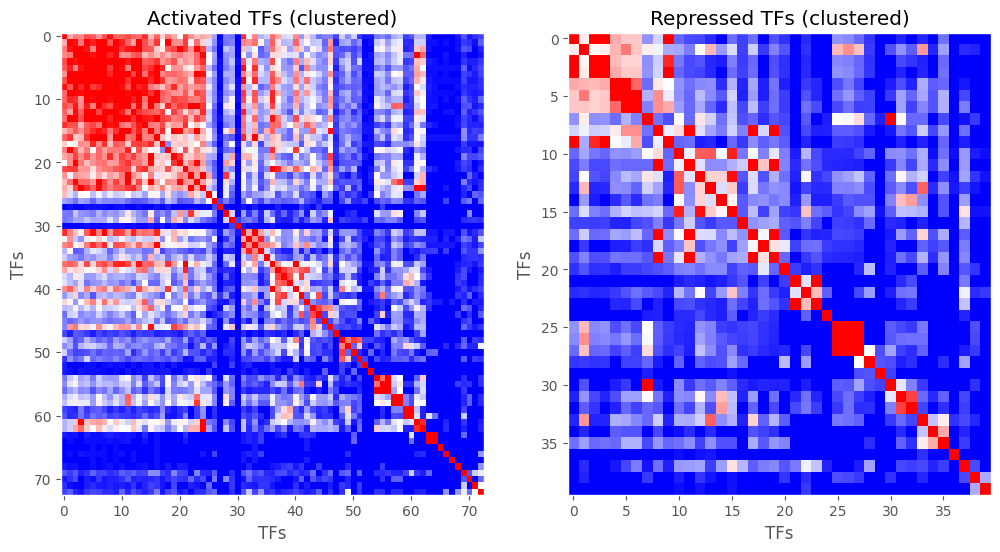

In [31]:
#Binarize and cluster Jaccard matrices
unmix_act = miner.cluster_distance_matrix(jaccard_matrix_act)
unmix_rep = miner.cluster_distance_matrix(jaccard_matrix_rep)

#Plot Jaccard matrices
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)

#Activated TFs subplot
ax1.imshow(jaccard_matrix_act.loc[np.hstack(unmix_act),np.hstack(unmix_act)],
           aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax1.grid(False)
ax1.set_ylabel("TFs")
ax1.set_xlabel("TFs")
ax1.set_title("Activated TFs (clustered)")

#Repressed TFs subplot
ax2.imshow(jaccard_matrix_rep.loc[np.hstack(unmix_rep),np.hstack(unmix_rep)],
           aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax2.grid(False)
ax2.set_ylabel("TFs")
ax2.set_xlabel("TFs")
ax2.set_title("Repressed TFs (clustered)")

#Save figure to file
plt.savefig(os.path.join(tf_network_directory,"clustered_tf_jaccard_matrices.pdf"),bbox_inches="tight")

## Infer master regulators

In [32]:
#Infer master regulators from the tf:downstream targets dictionary, network degree information, and tf clusters
master_act_list, master_act_dict, selected_acts = miner.infer_master_regulators(coverage_dict_act, network_degrees, unmix_act)
master_rep_list, master_rep_dict, selected_reps = miner.infer_master_regulators(coverage_dict_rep, network_degrees, unmix_rep)

Master regulators: ['FOXJ3']
Master regulators: ['E2F1', 'MYBL2', 'TP53']


In [33]:
#Write shortlist of TFs to file
selected_acts.to_csv(os.path.join(tf_network_directory,"selected_activators.csv"))
selected_reps.to_csv(os.path.join(tf_network_directory,"selected_repressors.csv"))

#Write master regulators to file
master_regulator_df = pd.DataFrame([(";").join(master_act_list),(";").join(master_rep_list)])
master_regulator_df.columns = ["master_regulators"]
master_regulator_df.index = ["activators","repressors"]
master_regulator_df.to_csv(os.path.join(tf_network_directory,"master_regulators.csv"))

#Write master regulators and downstream targets (children + grandchildren) to file
miner.write_json(master_act_dict,os.path.join(tf_network_directory,"master_activators.json"))
miner.write_json(master_rep_dict,os.path.join(tf_network_directory,"master_repressors.json"))

## Investigate tf-tf network for master regulator partners

In [34]:
#If a tf both activates and is activated by a master regulator, it is a partner
master_act_partners = miner.master_partners(master_act_list,tf_network)
master_rep_partners = miner.master_partners(master_rep_list,tf_network)

Discovered master partners: [['FOXJ3', 'POU2F1']]
Discovered master partners: [['E2F1', 'FOXM1'], ['TP53', 'FLI1']]


In [35]:
#Format master partners for inclusion in dataframe
master_pairs_act = [(";").join(p) for p in master_act_partners if len(master_act_partners)>0]
master_pairs_rep = [(";").join(p) for p in master_rep_partners if len(master_rep_partners)>0]

#Write master partners to file
master_pairs = list(np.hstack([master_pairs_act,master_pairs_rep]))
if len(master_pairs)>0:
    master_pairs_df = pd.DataFrame(master_pairs)
    master_pairs_df.columns = ["master_regulator_pair"]
    master_pair_types = pd.DataFrame([np.hstack([["activator" for i in range(len(master_pairs_act))],
                                                ["repressor" for i in range(len(master_pairs_rep))]])]).T
    master_pair_types.columns = ["type"]
    master_pairs_df = pd.concat([master_pair_types,master_pairs_df],axis=1)
    print(master_pairs_df)
    master_pairs_df.to_csv(os.path.join(tf_network_directory,"master_regulator_partners.csv"))

        type master_regulator_pair
0  activator          FOXJ3;POU2F1
1  repressor            E2F1;FOXM1
2  repressor             TP53;FLI1
